The idea behind this project is to build a model for predicting CNX Nifty movements. Algorithms used will try to predict the direction of tomorrow’s exchange closing price, whether it is going to be lower or higher with respect to today's price. Decision process involves CNX Nifty daily returns over the period of time. 

At the end I have written a simple trading strategy if the probability of the day will be “up”, zthe strategy purchases 500 shares of CNX Nifty and sells it at the end of the day. I start with 1M INR and buy and sell only playing with this amount of money. And finally compare the result against benchmark.

<b>Features:</b>

    CNX Nifty 50
    NASDAQ Composite 
	Frankfurt DAX 
	London FTSE-100 
	Tokyo Nikkei-225
	Hong Kong Hang Seng 
	Australia ASX-200 
	Shanghai Composite Index
	 

I have used yahoo as a data source. Downloaded data-frame contains the following columns:

	Date      :  in days
	Open      :  price of the stock at the opening of the trading
	High      :  highest price of the stock during the trading day
	Low       :  lowest price of the stock during the trading day
	Close     :  price of the stock at the closing of the trading
	Volume    :  amount of stocks traded
	Adj Close :  price of the stock at the closing of the trading
                    adjusted with dividends 
I am maily interested in the Adj Close.


In [262]:
%pylab inline
import Quandl as qd
import pandas as pd
import pandas.io.data
import seaborn
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [263]:
def fetch_data_from_yahoo(symbol, start, end):
    df =  pandas.io.data.get_data_yahoo(symbol, start, end)
    return df

In [264]:
def fetch_and_save_data(symbols, names, start, end):
    ret_df=[]
    for symbol, name in zip(symbols, names):
        df = fetch_data_from_yahoo(symbol, start, end)
        df.to_csv('./Data/'+name+'_'+start+'_'+end+'.csv',mode='w')
        ret_df.append(df)
    return ret_df        

In [265]:
def daily_return(dataset):
    dataset['Daily Return'] = dataset['Adj Close'].pct_change()
    return dataset

In [266]:
def plot_data(data_frames, names, subplot=False, market_names=[]):
    import math
    row = math.ceil((len(data_frames)*1.0)/2)
    if subplot:
        plt.figure((1), figsize=(80,30))
    i=1
    for data_frame in data_frames:
        if subplot:
            plt.subplot(row, 2, i)
        if(len(names)==1):
            data_frame[names].plot(ax=plt.gca())
        else:
            df=[]
            for name in names:
                df.append(data_frame[name])
            d = pd.concat(df, axis=1)
            d.plot() 
            plt.title("========= Data ====== ")
            plt.legend(loc='best')
        i += 1

In [267]:
def get_moving_average(data_frame, intervals):
    for interval in intervals:
        data_frame['MA_'+str(interval)] = pd.rolling_mean(data_frame['Adj Close'], interval)  
    return data_frame

In [268]:
def get_ewma(data_frame, intervals):
    for interval in intervals:
        data_frame['EMA_'+str(interval)] = pd.ewma(data_frame['Adj Close'], span=interval)  
    return data_frame

In [269]:
def concat(a, b):
    return a+b

In [270]:
def renamme_columns(data_frames, market_names):
    for market_name,data_frame in zip(market_names, data_frames):
        columns = data_frame.columns
        data_frame.rename(columns=lambda x: concat(x, '_'+market_name), inplace=True)

In [271]:
def merge_data_frames(datasets, index):
    return pd.concat([data_frame.ix[:, index:] for data_frame in data_frames], axis=1)

In [272]:
def count_missing(dataframe):
    return (dataframe.shape[0] * dataframe.shape[1]) - dataframe.count().sum()

Add an extra column in the data frame for change in daily return. If rtuern is greater than 0 make it +1 else -1.
<br/>Split data into training and test data.

In [273]:
def prepare_data_for_classification(dataset, start_test):
    le = preprocessing.LabelEncoder()

    dataset['UpDown'] = dataset['Daily Return_nse']

    dataset.UpDown[dataset.UpDown >= 0] = 1
    dataset.UpDown[dataset.UpDown < 0] = -1

    dataset['UpDown'].fillna(1, inplace=True)

    #dataset.UpDown = le.fit(dataset.UpDown).transform(dataset.UpDown)

    features = dataset.columns[1:-1]
    X = dataset[features]
    y = dataset.UpDown

    X_train = X[X.index < start_test]
    y_train = y[y.index < start_test]

    X_test = X[X.index >= start_test]
    y_test = y[y.index >= start_test]

    return X_train, y_train, X_test, y_test

====================================================================================================================
<b> Machine Learning Related Functions </b>

In [274]:
def apply_svc(X_train,y_train, X_test, y_test, kernel='linear', C=1):
    clf = SVC(kernel=kernel, C=C)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print("Accuracy for SVM Classifier %s" %accuracy)

In [275]:
def apply_knn(X_train,y_train, X_test, y_test):
    clf = neighbors.KNeighborsClassifier()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print("Accuracy for KNN Classifier %s" %accuracy) 

In [276]:
def apply_random_forest(X_train,y_train, X_test, y_test):
    clf = RandomForestClassifier(n_estimators=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print("Accuracy for RF Classifier %s" %accuracy) 

In [277]:
def select_best_param_svc(X_train,y_train,parameters):
    svr=SVC()
    clf = GridSearchCV(svr, parameters)
    clf.fit(X_train, y_train)
    print ("Best Parameter SVC",clf.best_params_)

In [278]:
def get_svc_prediction(X_train,y_train, x_predict, kernel='linear', C=1):
    clf = SVC(kernel=kernel, C=C)
    clf.fit(X_train, y_train)
    return clf.predict(x_predict)

** Porfolio Analysis

In [279]:
class MarketIntradayPortfolio():
    
    def __init__(self, symbol, bars, signals, initial_capital=1000000.0, shares=500):
        self.symbol = symbol        
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.shares = int(shares)
        self.positions = self.generate_positions()
    
    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)
 
        positions[self.symbol] = self.shares*self.signals['signal']
        return positions
    
    def backtest_portfolio(self):
        portfolio = pd.DataFrame(index=self.positions.index)
        pos_diff = self.positions.diff()
            
        portfolio['price_diff'] = self.bars['Adj Close']-self.bars['Open']
        portfolio['price_diff'][0:5] = 0.0
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff']
     
        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

===================================================================================================================

In [280]:
start_date='2014-01-01'
end_date='2015-10-01'

In [281]:
indices=['^NSEI','^DJI','^FTSE','^AXJO','^HSI','^N225','^IXIC','000001.SS']
market_name=['nse','dji','ftse','aus','hsi', 'nikkei','nasdaq','sanghai']

In [282]:
data_frames=fetch_and_save_data(indices, market_name, start_date, end_date)

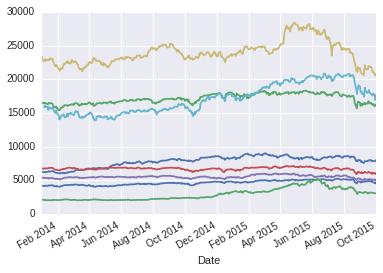

In [283]:
for data_frame in data_frames:
    data_frame['Adj Close'].plot()

In [284]:
for data_frame in data_frames:
    daily_return(data_frame)

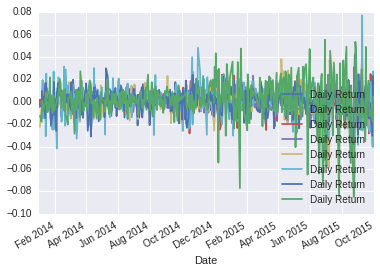

In [285]:
plot_data(data_frames, ['Daily Return'])

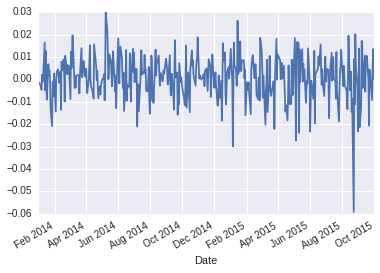

In [286]:
data_frames[0]['Daily Return'].plot()

In [287]:
data_frames[0].index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15', 
               ...
               '2015-09-16', '2015-09-18', '2015-09-21', '2015-09-22',
               '2015-09-23', '2015-09-24', '2015-09-28', '2015-09-29',
               '2015-09-30', '2015-10-01'],
              dtype='datetime64[ns]', name='Date', length=427, freq=None, tz=None)

In [288]:
for data_frame in data_frames:
    data_frame = get_moving_average(data_frame, [5,10,15,20])

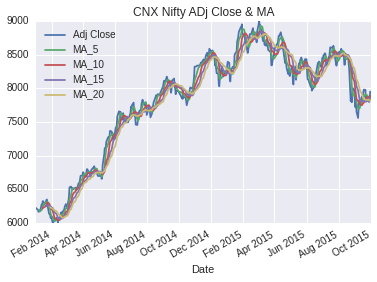

In [289]:
cols=['Adj Close','MA_5','MA_10','MA_15','MA_20']
for col in cols:
    data_frames[0][col].plot(legend=True)
    plt.title('CNX Nifty ADj Close & MA')

In [290]:
for data_frame in data_frames:
    data_frame = get_ewma(data_frame, [5,10,15,20])

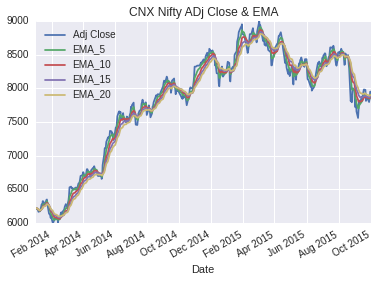

In [291]:
cols=['Adj Close','EMA_5','EMA_10','EMA_15','EMA_20']
for col in cols:
    data_frames[0][col].plot(legend=True)
    plt.title('CNX Nifty ADj Close & EMA')

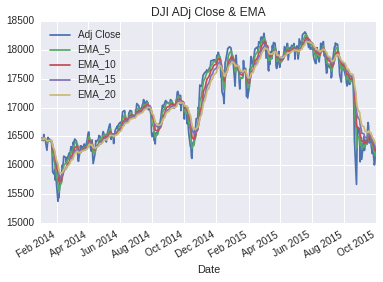

In [292]:
cols=['Adj Close','EMA_5','EMA_10','EMA_15','EMA_20']
for col in cols:
    data_frames[1][col].plot(legend=True)
    plt.title('DJI ADj Close & EMA')

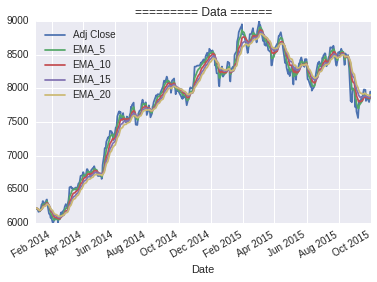

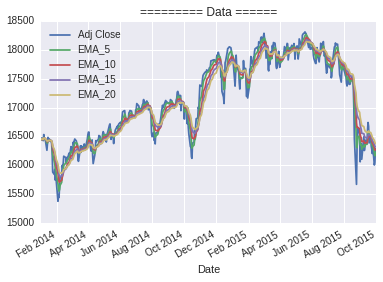

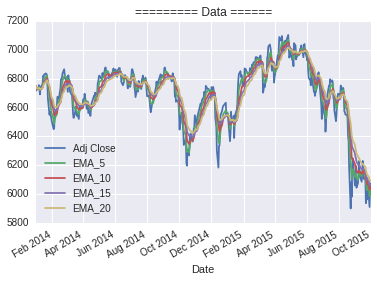

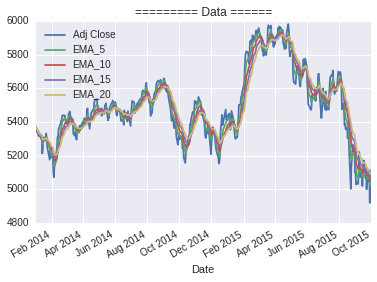

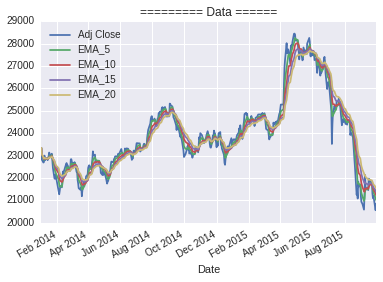

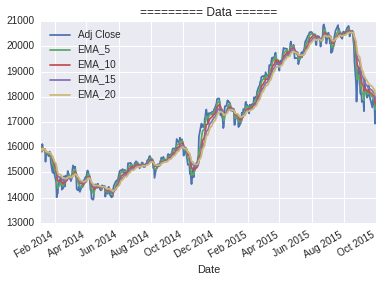

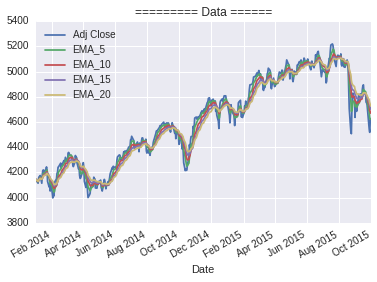

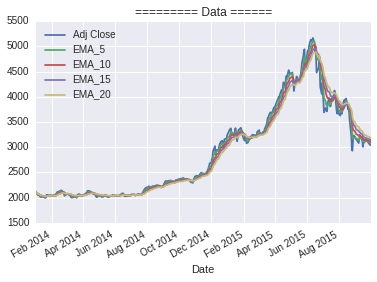

In [293]:
for data_frame in data_frames:
    data_frame=get_ewma(data_frame, [5,10,15,20])
plot_data(data_frames, ['Adj Close','EMA_5','EMA_10','EMA_15','EMA_20'])

In [294]:
renamme_columns(data_frames, market_name)

In [295]:
data_frames[1].index.name

'Date'

In [296]:
print(data_frames[1].columns)

Index(['Open_dji', 'High_dji', 'Low_dji', 'Close_dji', 'Volume_dji',
       'Adj Close_dji', 'Daily Return_dji', 'MA_5_dji', 'MA_10_dji',
       'MA_15_dji', 'MA_20_dji', 'EMA_5_dji', 'EMA_10_dji', 'EMA_15_dji',
       'EMA_20_dji'],
      dtype='object')


* Data point counts

In [297]:
for name, data_frame in zip(market_name, data_frames):
    print ("No of Data for [%8s] are [%s]"%(name,len(data_frame)))

No of Data for [     nse] are [427]
No of Data for [     dji] are [441]
No of Data for [    ftse] are [444]
No of Data for [     aus] are [445]
No of Data for [     hsi] are [433]
No of Data for [  nikkei] are [440]
No of Data for [  nasdaq] are [441]
No of Data for [ sanghai] are [423]


<b> Merge Data Frames </b>
<br/> We are interested in colums after Adjusted close.

In [298]:
merged_data = merge_data_frames(data_frames, 5)

In [299]:
print(merged_data.columns)

Index(['Adj Close_nse', 'Daily Return_nse', 'MA_5_nse', 'MA_10_nse',
       'MA_15_nse', 'MA_20_nse', 'EMA_5_nse', 'EMA_10_nse', 'EMA_15_nse',
       'EMA_20_nse', 'Adj Close_dji', 'Daily Return_dji', 'MA_5_dji',
       'MA_10_dji', 'MA_15_dji', 'MA_20_dji', 'EMA_5_dji', 'EMA_10_dji',
       'EMA_15_dji', 'EMA_20_dji', 'Adj Close_ftse', 'Daily Return_ftse',
       'MA_5_ftse', 'MA_10_ftse', 'MA_15_ftse', 'MA_20_ftse', 'EMA_5_ftse',
       'EMA_10_ftse', 'EMA_15_ftse', 'EMA_20_ftse', 'Adj Close_aus',
       'Daily Return_aus', 'MA_5_aus', 'MA_10_aus', 'MA_15_aus', 'MA_20_aus',
       'EMA_5_aus', 'EMA_10_aus', 'EMA_15_aus', 'EMA_20_aus', 'Adj Close_hsi',
       'Daily Return_hsi', 'MA_5_hsi', 'MA_10_hsi', 'MA_15_hsi', 'MA_20_hsi',
       'EMA_5_hsi', 'EMA_10_hsi', 'EMA_15_hsi', 'EMA_20_hsi',
       'Adj Close_nikkei', 'Daily Return_nikkei', 'MA_5_nikkei',
       'MA_10_nikkei', 'MA_15_nikkei', 'MA_20_nikkei', 'EMA_5_nikkei',
       'EMA_10_nikkei', 'EMA_15_nikkei', 'EMA_20_nikkei', 'Adj

In [300]:
merged_data.describe()

,Adj Close_nse,Daily Return_nse,MA_5_nse,MA_10_nse,MA_15_nse,MA_20_nse,EMA_5_nse,EMA_10_nse,EMA_15_nse,EMA_20_nse,...,Adj Close_sanghai,Daily Return_sanghai,MA_5_sanghai,MA_10_sanghai,MA_15_sanghai,MA_20_sanghai,EMA_5_sanghai,EMA_10_sanghai,EMA_15_sanghai,EMA_20_sanghai
count,427.000000,426.000000,423.000000,418.000000,413.000000,408.000000,427.000000,427.000000,427.000000,427.000000,...,423.000000,422.000000,419.000000,414.000000,409.000000,404.000000,423.000000,423.000000,423.000000,423.000000
mean,7810.468505,0.000621,7817.567121,7827.017755,7836.272135,7846.010212,7802.533460,7792.834024,7783.026062,7772.858410,...,2899.114113,0.001058,2902.231265,2906.211826,2910.265563,2914.271177,2894.414789,2888.121689,2881.350055,2873.963727
std,805.226468,0.009461,798.306257,789.660045,781.467644,773.338324,808.083194,812.579231,817.227741,821.808693,...,894.128517,0.018940,894.105989,893.875397,893.214126,892.417181,891.939344,889.246038,886.059700,882.281676
min,6000.899902,-0.059151,6024.919922,6037.420020,6057.146680,6075.990039,6042.132893,6059.836664,6078.528383,6092.961172,...,1991.250000,-0.084907,2004.272000,2013.306000,2023.890000,2025.760000,2008.778877,2016.181865,2020.558451,2023.196263
25%,7493.275147,-0.003852,7533.135156,7551.065088,7565.686751,7560.066937,7527.669422,7488.970944,7414.885407,7348.472141,...,2068.870000,-0.006428,2064.206000,2070.936500,2080.058667,2077.209375,2066.330416,2068.353949,2068.139487,2065.728261
50%,8017.549805,0.000848,8037.320019,8070.552515,8080.460059,8072.701294,8034.997041,8054.342160,8028.980070,8011.130370,...,2473.670000,0.001420,2469.160000,2468.876000,2472.455333,2486.693750,2462.814752,2451.568378,2433.191190,2418.515966
75%,8411.450195,0.006112,8419.679981,8431.664941,8430.903255,8429.108716,8419.644203,8411.505597,8392.099088,8381.719204,...,3579.785000,0.009261,3589.168000,3577.360250,3579.313333,3577.753875,3536.014498,3516.919529,3492.411939,3497.571526
max,8996.250000,0.029873,8931.600000,8845.974902,8839.716536,8807.152392,8913.929201,8870.787918,8838.603612,8809.378302,...,5166.350000,0.055314,5127.878000,5052.791000,4971.617333,4925.927000,5107.789023,5028.316114,4951.379227,4887.240400


In [301]:
merged_data.Return_CNX_NIFTY = merged_data['Daily Return_nse'].shift(-1)

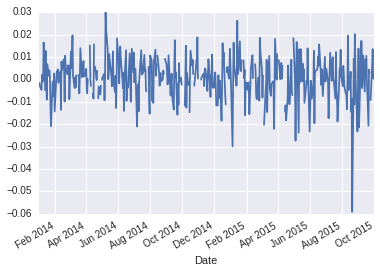

In [302]:
merged_data.Return_CNX_NIFTY.plot()

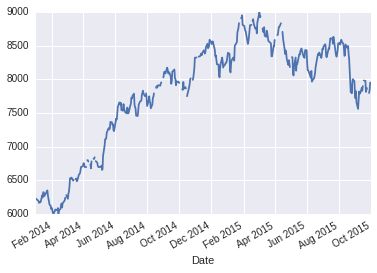

In [303]:
merged_data['Adj Close_nse'].plot()

Due to missing data plot is broken.

<b> Count missing data(NaN) after simple merge</b>
* Fill the missing data.

In [304]:
print("Shape of merged data",merged_data.shape,".")
print("After merge out of [",len(merged_data)*len(merged_data.columns),"] [",count_missing(merged_data),"] data points are missing.")

Shape of merged data (456, 80) .
After merge out of [ 36480 ] [ 1916 ] data points are missing.


In [305]:
merged_data = merged_data.interpolate(method='time')
print ('Number of NaN after time interpolation: %s' % str(count_missing(merged_data)))

Number of NaN after time interpolation: 471


In [306]:
merged_data = merged_data.fillna(merged_data.mean())
print ('Number of NaN after mean interpolation: %s' %count_missing(merged_data)) 

Number of NaN after mean interpolation: 0


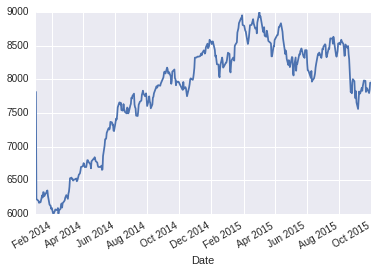

In [307]:
merged_data['Adj Close_nse'].plot()

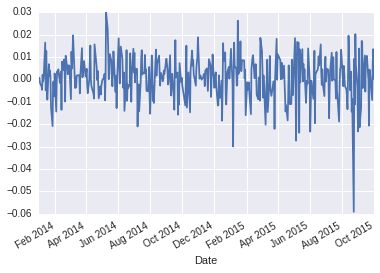

In [308]:
merged_data['Daily Return_nse'].plot()

* Prepare data for classification.

In [309]:
X_train, y_train, X_test, y_test = prepare_data_for_classification(merged_data['2014-01-01':'2015-08-01'], '2015-06-01')

/opt/Tools/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/Tools/anaconda3/lib/python3.4/site-packages/pandas/core/generic.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/Tools/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__

In [310]:
print ("======== Shapes ======== ")
print ("Training X",X_train.shape)
print ("Training y",y_train.shape)
print ("Test     X",X_test.shape)
print ("Test     y",y_test.shape)
print ("======================== ")


======== Shapes ======== 
Training X (367, 79)
Training y (367,)
Test     X (45, 79)
Test     y (45,)


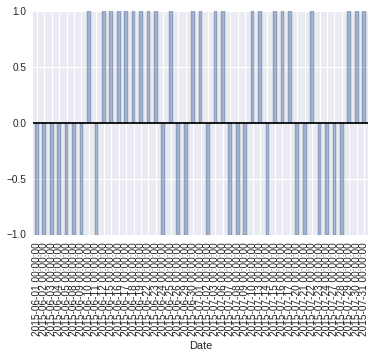

In [311]:
plt.figure()
y_test.plot(kind='bar', alpha=0.5)
plt.axhline(0, color='k')

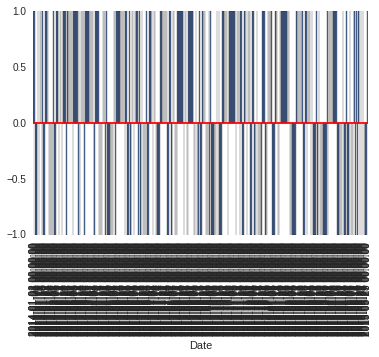

In [312]:
plt.figure()
y_train.plot(kind='bar', alpha=0.9)
plt.axhline(0, color='r')

In [313]:
print ("Postive and negative movement in train data outcome.")
print (y_train.value_counts())
print ("Postive and negative movement in test data outcome.")
print (y_test.value_counts())

Postive and negative movement in train data outcome.
 1    206
-1    161
dtype: int64
Postive and negative movement in test data outcome.
 1    23
-1    22
dtype: int64


Data points are evenly distributed.

* Finally done with data cleaning. Now time to apply some machine learning.

===================================================================================================================
<br/> Machine Learning classifier 

In [314]:
apply_svc(X_train, y_train, X_test, y_test)

Accuracy for SVM Classifier 0.622222222222


In [315]:
apply_knn(X_train, y_train, X_test, y_test)

Accuracy for KNN Classifier 0.533333333333


#### With the same input output is different  

In [318]:
apply_random_forest(X_train, y_train, X_test, y_test)

Accuracy for RF Classifier 0.933333333333


In [319]:
apply_random_forest(X_train, y_train, X_test, y_test)

Accuracy for RF Classifier 0.977777777778


### Strange behavior
According to Scikit learn GridSearchCV best parameters for svc is kernel=rbf and C=1. But when I feed the data SVC kernel linear has better result which is suprising. 

In [320]:
parameters = {'kernel':( 'linear', 'rbf'), 'C':[1, 10]}
select_best_param_svc(X_train, y_train, parameters)

Best Parameter SVC {'kernel': 'rbf', 'C': 1}


In [321]:
apply_svc(X_train, y_train, X_test, y_test, kernel='rbf', C=1)

Accuracy for SVM Classifier 0.511111111111


In [322]:
apply_svc(X_train, y_train, X_test, y_test, kernel='linear', C=1)

Accuracy for SVM Classifier 0.622222222222


==================================================================================================================
###### Test against Benchmark

In [323]:
b_start_date='2015/07/30'
b_end_date='2015/10/01'

In [325]:
symbol = 'CNX-NIFTY'
bars = fetch_data_from_yahoo('^NSEI', b_start_date, b_end_date)

X_train, y_train, X_test, y_test = prepare_data_for_classification(merged_data, '2015-08-01')
predict=get_svc_prediction(X_train, y_train, X_test)

In [331]:
signals = pd.DataFrame(index=bars.index)
signals['signal'] = 0.0
signals['signal'] = predict

In [334]:
signals['positions'] = signals['signal'].diff()     
 
portfolio = MarketIntradayPortfolio(symbol, bars, signals) 
returns = portfolio.backtest_portfolio()
print (returns.tail(5))

            price_diff      profit         total   returns
Date                                                      
2015-09-24   30.100098  15050.0490  1283575.4410  0.011864
2015-09-28  -97.099610  48549.8050  1332125.2460  0.037824
2015-09-29  117.599610 -58799.8050  1273325.4410 -0.044140
2015-09-30   24.649902  12324.9510  1285650.3920  0.009679
2015-10-01  -41.149903 -20574.9515  1265075.4405 -0.016004


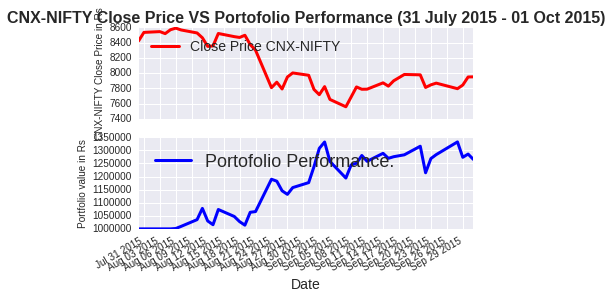

In [330]:
f, ax = plt.subplots(2, sharex=True)
f.patch.set_facecolor('white')
ylabel = symbol + ' Close Price in Rs'
bars['Close'].plot(ax=ax[0], color='r', lw=3.)    
ax[0].set_ylabel(ylabel, fontsize=10)
ax[0].set_xlabel('', fontsize=14)
ax[0].legend(('Close Price CNX-NIFTY',), loc='upper left', prop={"size":14})
ax[0].set_title('CNX-NIFTY Close Price VS Portofolio Performance (31 July 2015 - 01 Oct 2015)', fontsize=16, fontweight="bold")

returns['total'].plot(ax=ax[1], color='b', lw=3.)  
ax[1].set_ylabel('Portfolio value in Rs', fontsize=10)
ax[1].set_xlabel('Date', fontsize=14)
ax[1].legend(('Portofolio Performance.',), loc='upper left', prop={"size":18})            
plt.tick_params(axis='both', which='major', labelsize=10)
loc = ax[1].xaxis.get_major_locator()
loc.maxticks[DAILY] = 24

plt.show()

** Performance **

Above is the CNX Nifty Close Price between 31 July 2015 and 01 October 2015. First graph shows the actual trend of the market index for above period. In this particular period the market had a return is negative (-4.76%).
<br/>
Portofolio return for the same period. Second graph shows the trend of the Porfolio generated on top of our predictions. Start value is 1M INR which end up at a final value, after 3 months of trading, of about 26%. 